### 1. Import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

### 2. Load dataset

In [3]:
df = pd.read_csv("dataset_dl.csv")

print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (29964, 5)
            a           b  opcode  faulty_result  fault_type
0   303379748  3230228097       4     3533466277           1
1  2985317987   112818957       2       11555329           0
2  2999092325  2302104082       1      696988243           0
3   114806029   992211318       2       50577668           1
4  1993627629  1177417612       4      821665889           0


### 3. Explore dataset

In [4]:
print("\nFault type distribution:")
print(df['fault_type'].value_counts())


Fault type distribution:
fault_type
1    10320
2     9918
0     9726
Name: count, dtype: int64


###  Plot distribution

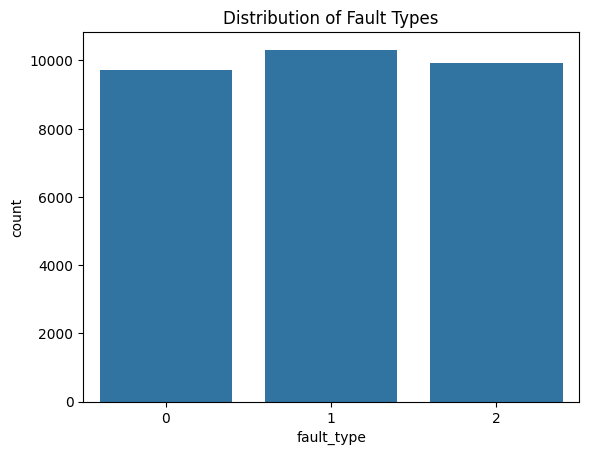

In [5]:
sns.countplot(x='fault_type', data=df)
plt.title("Distribution of Fault Types")
plt.show()

In [6]:
# --- ADD THIS CODE TO A NEW CELL IN YOUR NOTEBOOK ---

# We need to assume the mapping from opcode number to operation.
# Based on the original project description, a common mapping would be:
# 0: ADD, 1: SUB, 2: AND, 3: OR, 4: XOR
def correct_alu_operation(row):
    """
    Simulates the correct 32-bit ALU operation for a given row of the DataFrame.
    """
    a = row['a']
    b = row['b']
    opcode = row['opcode']

    # Use a bitmask to ensure all operations are 32-bit
    MASK = 0xFFFFFFFF

    if opcode == 0:   # ADD
        return (a + b) & MASK
    elif opcode == 1: # SUB
        return (a - b) & MASK
    elif opcode == 2: # AND
        return a & b
    elif opcode == 3: # OR
        return a | b
    elif opcode == 4: # XOR
        return a ^ b
    else:
        return 0

# 1. Calculate the 'correct_result' for every row in the dataframe
df['correct_result'] = df.apply(correct_alu_operation, axis=1)

# 2. Create the powerful 'error_bits' feature using XOR.
# This feature will be 0 if the result is correct, and will have bits set
# to 1 where the faulty and correct results differ.
df['error_bits'] = df['faulty_result'] ^ df['correct_result']

# Display the new columns to verify
print("DataFrame with new features:")
print(df[['a', 'b', 'opcode', 'faulty_result', 'correct_result', 'error_bits', 'fault_type']].head())

DataFrame with new features:
            a           b  opcode  faulty_result  correct_result  error_bits  \
0   303379748  3230228097       4     3533466277      3533466533         256   
1  2985317987   112818957       2       11555329        11555329           0   
2  2999092325  2302104082       1      696988243       696988243           0   
3   114806029   992211318       2       50577668        33800452    16777216   
4  1993627629  1177417612       4      821665889       821665889           0   

   fault_type  
0           1  
1           0  
2           0  
3           1  
4           0  


### 4. Define features (X) and labels (y)

In [7]:
# --- NEW CODE ---
# We now include 'error_bits' which is a much better feature!
X = df[['a', 'b', 'opcode', 'faulty_result', 'error_bits']].values
y = df['fault_type'].values

print("Feature shape:", X.shape)
print("Label shape:", y.shape)

Feature shape: (29964, 5)
Label shape: (29964,)


### 5. Train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale inputs for better training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 6. Build MLP model

In [9]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

d:\mini_project\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,563 (10.01 KB)

 Trainable params: 2,563 (10.01 KB)

 Non-trainable params: 0 (0.00 B)

### 7. Train the model

In [10]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4828 - loss: 0.9519 - val_accuracy: 0.5351 - val_loss: 0.8525
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5244 - loss: 0.8730 - val_accuracy: 0.5397 - val_loss: 0.8374
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5291 - loss: 0.8543 - val_accuracy: 0.5481 - val_loss: 0.8163
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5383 - loss: 0.8403 - val_accuracy: 0.5527 - val_loss: 0.8082
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5421 - loss: 0.8331 - val_accuracy: 0.5514 - val_loss: 0.8023
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5426 - loss: 0.8212 - val_accuracy: 0.5710 - val_loss: 0.7886
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5445 - loss: 0.8114 - val_accuracy: 0.5595 - val_loss: 0.7803
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5499 - loss: 0.8007 - val_accuracy: 0.

### 8. Plot training history

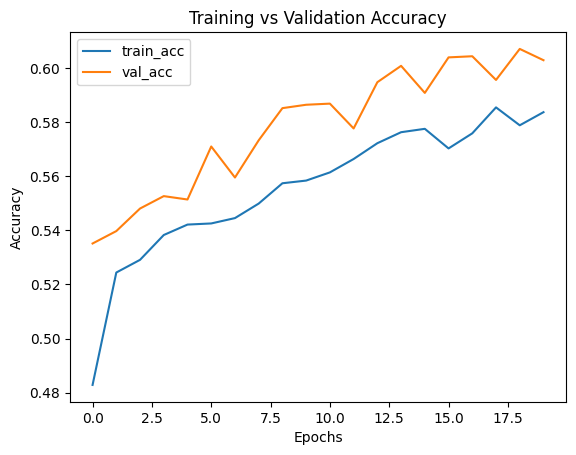

In [11]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 9. Evaluate on test set

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


Test Accuracy: 59.74%


### 10. Confusion Matrix & Report

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


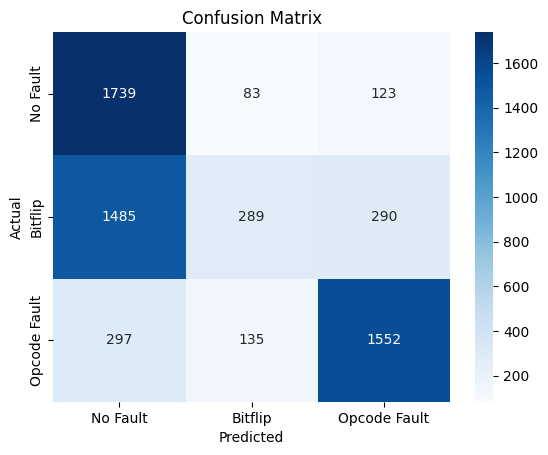


Classification Report:
              precision    recall  f1-score   support

    No Fault       0.49      0.89      0.64      1945
     Bitflip       0.57      0.14      0.22      2064
Opcode Fault       0.79      0.78      0.79      1984

    accuracy                           0.60      5993
   macro avg       0.62      0.61      0.55      5993
weighted avg       0.62      0.60      0.54      5993



In [13]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fault", "Bitflip", "Opcode Fault"],
            yticklabels=["No Fault", "Bitflip", "Opcode Fault"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Fault", "Bitflip", "Opcode Fault"]))